# Exploratory Data Analysis (EDA) and Visualization

## Payment Date Prediction 

This project provides an end-to-end analysis of the [Kaggle Payment Date Dataset](https://www.kaggle.com/datasets/rajattomar132/payment-date-dataset).

**Key steps:**

* **Data Cleaning:** Robust parsing of mixed date formats, duplicate removal, treating IDs as strings.
* **Feature Engineering:** Days-to-clear, days-late, late flags, aging buckets, observed vs agreed terms, standardized customer names.
* **Finance Metrics:** Monthly cohorts, DSO proxy, amount-weighted late rates, Pareto of late customers.
* **Model Readiness:** Temporal train/test split to avoid leakage.
* **Visualization:** Static (Seaborn/Matplotlib) and interactive (Plotly) charts showing lateness distributions, DSO trend, aging mix, customer risk.

**Outcome:** A finance-focused pipeline that surfaces actionable insights into cash collection performance, payment behavior, and customer risk exposure.

In [1]:
# ==============================
# Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# ==============================
# Load Dataset
# ==============================
# Replace with your dataset path
df = pd.read_csv("dataset.csv")

print("Raw shape:", df.shape)

# ==============================
# Basic Info
# ==============================
print("Shape:", df.shape)
print("\nColumn Overview:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isna().sum())

Raw shape: (50000, 19)
Shape: (50000, 19)

Column Overview:
business_code              object
cust_number                object
name_customer              object
clear_date                 object
buisness_year               int64
doc_id                      int64
posting_date               object
document_create_date        int64
document_create_date.1      int64
due_in_date                 int64
invoice_currency           object
document type              object
posting_id                  int64
area_business             float64
total_open_amount         float64
baseline_create_date        int64
cust_payment_terms         object
invoice_id                float64
isOpen                      int64
dtype: object

Missing Values:
business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
documen

## Business/Finance Implications

* Roughly **20% of invoices are open/unpaid** (10,000/50,000), which is significant — indicates high AR exposure.
* Presence of **multiple date fields** (`posting_date`, `baseline_create_date`, `due_in_date`, `clear_date`) is excellent — allows computation of **payment delays, due-date adherence, and baseline-to-clear variance**.
* The dataset is clean in key financial fields (`total_open_amount`, `cust_payment_terms`), which means we can analyze **customer payment behavior across terms**.

In [3]:
# ==============================
# Basic cleaning
# ==============================
# 1) Drop columns that are completely unusable (all-null)
if "area_business" in df.columns and df["area_business"].isna().all():
    df = df.drop(columns=["area_business"])

# 2) Ensure identifiers stay as strings (avoids scientific notation & precision loss)
for c in ["cust_number", "doc_id", "invoice_id"]:
    if c in df.columns:
        df[c] = df[c].astype(str)

In [4]:
# ==============================
# Date parsing (CRITICAL FIX)
# ==============================
# Columns stored as integers like 20200126 -> must use format="%Y%m%d"
INT_DATE_COLS = ["document_create_date", "document_create_date.1", "due_in_date", "baseline_create_date"]
for c in INT_DATE_COLS:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c].astype(str), format="%Y%m%d", errors="coerce")

# String-like date columns (let pandas infer)
for c in ["posting_date", "clear_date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Sanity check
print(df[["posting_date","due_in_date","clear_date","baseline_create_date"]].head())


  posting_date due_in_date clear_date baseline_create_date
0   2020-01-26  2020-02-10 2020-02-11           2020-01-26
1   2019-07-22  2019-08-11 2019-08-08           2019-07-22
2   2019-09-14  2019-09-29 2019-12-30           2019-09-14
3   2020-03-30  2020-04-10        NaT           2020-03-31
4   2019-11-13  2019-11-28 2019-11-25           2019-11-13


In [5]:
# ==============================
# Closed vs Open; core targets
# ==============================
closed_mask = df["isOpen"].eq(0)

# Compute only for closed invoices (open ones lack clear_date)
df.loc[closed_mask, "days_to_clear"] = (df.loc[closed_mask, "clear_date"] - df.loc[closed_mask, "posting_date"]).dt.days
df.loc[closed_mask, "days_late"]     = (df.loc[closed_mask, "clear_date"] - df.loc[closed_mask, "due_in_date"]).dt.days

df["is_late"] = (df["days_late"] > 0)
print("\nClosed invoices:", int(closed_mask.sum()), "/", len(df))
print("Late rate (closed, unweighted):", df.loc[closed_mask, "is_late"].mean().round(3))



Closed invoices: 40000 / 50000
Late rate (closed, unweighted): 0.419


In [6]:
# ==============================
# Standardize customer names (reduce 'corp/llc/co' variants)
# ==============================
SUFFIXES = r"( corporation| corp| co| llc| inc| systems| associates| foundation| trust| ltd)\b"
df["name_customer_std"] = (
    df["name_customer"].astype(str).str.lower()
      .str.replace(SUFFIXES, "", regex=True)
      .str.replace(r"[^a-z0-9 ]", "", regex=True)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

In [7]:
# ==============================
# Classic AR metrics
# ==============================
# 1) Aging buckets
bins   = [-10**6, 0, 15, 30, 60, 90, 10**6]
labels = ["Current/early", "1–15", "16–30", "31–60", "61–90", ">90"]
df.loc[closed_mask, "aging_bucket"] = pd.cut(df.loc[closed_mask, "days_late"], bins=bins, labels=labels)

# 2) Observed terms & term discipline (did we beat/miss terms?)
df["term_days_observed"] = (df["due_in_date"] - df["baseline_create_date"]).dt.days
df.loc[closed_mask, "term_delta"] = df.loc[closed_mask, "days_to_clear"] - df.loc[closed_mask, "term_days_observed"]
# term_delta > 0 => paid later than terms; < 0 => earlier than terms

# 3) Amount-weighted KPIs per customer (cash impact matters)
def weighted_kpis(g):
    g = g[g["isOpen"].eq(0)]                                # only closed
    if g.empty or g["total_open_amount"].sum() == 0:
        return pd.Series({"late_rate_amt": np.nan, "avg_days_late_amt": np.nan})
    amt = g["total_open_amount"]
    late = g["is_late"].fillna(False)
    days = g["days_late"].clip(-60, 180)                    # clip for stability in weighting
    return pd.Series({
        "late_rate_amt": amt[late].sum() / amt.sum(),
        "avg_days_late_amt": np.average(days.dropna(), weights=amt.loc[days.dropna().index])
    })

amt_kpis = (df.groupby("name_customer_std", dropna=False)
              .apply(weighted_kpis)
              .sort_values("late_rate_amt", ascending=False))
print("\nTop (amount-weighted) late-rate customers:\n", amt_kpis.head(10))

# 4) Monthly cohorts (posting month)
df["post_month"] = df["posting_date"].dt.to_period("M")
closed_df = df[df["isOpen"].eq(0)].copy()

cohort = closed_df.groupby("post_month").agg(
    invoices=("doc_id","count"),
    late_rate=("is_late","mean"),
    amt=("total_open_amount","sum"),
)
cohort["amt_late"] = closed_df[closed_df["is_late"]].groupby("post_month")["total_open_amount"].sum()
cohort["amt_late"] = cohort["amt_late"].fillna(0.0)
cohort["amt_late_rate"] = cohort["amt_late"] / cohort["amt"]
print("\nMonthly cohort preview:\n", cohort.tail(6))

# 5) DSO-style proxy (bounded by closed invoices)
dso = closed_df["days_to_clear"].mean()
print("\nDSO proxy (avg days to collect on closed invoices):", round(float(dso), 2))


Top (amount-weighted) late-rate customers:
                    late_rate_amt  avg_days_late_amt
name_customer_std                                  
11078 us                     1.0          17.000000
java                         1.0           1.633806
intersta                     1.0           1.000000
ittell                       1.0          32.000000
itwa in                      1.0           2.000000
jacmar                       1.0           2.526463
jacmar us                    1.0           2.220195
jake in                      1.0           7.000000
jali                         1.0           5.616046
jam in                       1.0           2.000000

Monthly cohort preview:
             invoices  late_rate           amt     amt_late  amt_late_rate
post_month                                                               
2019-09         2957   0.424078  9.483665e+07  40860826.52       0.430855
2019-10         3117   0.410010  1.041241e+08  45460716.94       0.436601
2019-11  

/var/folders/4m/0t9dj_dj6r7cs3h7ks8tv2v40000gn/T/ipykernel_1822/1978243171.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_kpis)


## Insights from Amount-Weighted KPIs

* The top customers (e.g., **ittell, 11078 us, jacmar**) all have a **late\_rate\_amt = 1.0**, meaning **100% of their invoice value is paid late**.
* However, their **avg\_days\_late\_amt** values are fairly low (1–7 days for most, 32 days for ittell).
* This shows these accounts **always pay late, but not extremely late** — they’re systematically missing due dates by small margins.
* Customers like **ittell (32 days late)** stand out as true risk — they combine **systematic lateness + material delay length**.
* Business takeaway → These customers should be flagged for **tightened credit terms or active collections monitoring**, since even short delays, when systematic, impact cash forecasting.

---

## Monthly Cohorts

* Between **Sep 2019 and Feb 2020**, invoices per month range between \~1.8k and \~3.1k.
* **Late rate (by invoice count)** hovers around **40–43%**.
* **Amount-weighted late rate** is very similar (\~40–48%), meaning **big invoices are just as likely to be late as small ones**.
* In **Dec 2019**, late behavior looks slightly better (32% invoices late, \~40% amount late) — could be a seasonal effect (year-end push to close books).
* Otherwise, the problem is **structural**, not a one-off event.
* Business takeaway → Persistent late behavior across months suggests **policy issues**, not temporary shocks.

---

## DSO Proxy

* **DSO = \~18 days** → on average, invoices are collected about **18 days after posting**.
* This is **quite good** compared to many industries (typical DSO ranges 30–60 days).
* However, the late-rate analysis above shows that this “good average” hides **chronic small delays** — so while DSO is low, **timeliness discipline is weak**.
* Business takeaway → Cash is coming in relatively fast overall, but AR managers should still push for **term compliance**, since systemic delays can balloon during downturns.


In [8]:
# ==============================
# Integrity & temporal split
# ==============================
dups = df.duplicated(subset=["doc_id"]).sum()
print("\nDuplicate doc_id count:", int(dups))

cutoff = df["posting_date"].dropna().quantile(0.8)
train = df[df["posting_date"] <= cutoff]
valid = df[df["posting_date"]  > cutoff]
print("Temporal split:", train.shape, valid.shape, "cutoff =", cutoff.date())


Duplicate doc_id count: 1161
Temporal split: (40152, 26) (9848, 26) cutoff = 2020-02-27


## Integrity Check: Duplicate `doc_id`

* I found **1,161 duplicate `doc_id` values**.
* Since `doc_id` is supposed to be a **unique document identifier**, duplicates suggest either:

  * The dataset includes **multiple records per invoice** (e.g., adjustments, currency entries, or credit notes).
  * Or the source system duplicated entries when exporting.
* Business/technical implication → You’ll need to decide whether to:

  * **Drop duplicates** and keep the first occurrence, if they are true duplicates.
  * Or **aggregate** them (sum of amounts, latest clear date) if they represent multi-line invoices.

Next step: I **examine a few duplicate doc\_id records** to see what they look like (same customer? same amount? different clear\_date?). That will tell you whether to drop or aggregate.

In [9]:
# Identify duplicate doc_ids
dupes = df[df.duplicated(subset=["doc_id"], keep=False)].sort_values("doc_id")

# Show a sample of duplicates
print("Total duplicate doc_ids:", dupes["doc_id"].nunique())
print("\nExample duplicate groups (first 5 doc_ids):")
for doc in dupes["doc_id"].unique()[:5]:
    print(f"\n--- doc_id: {doc} ---")
    display(df[df["doc_id"] == doc])


Total duplicate doc_ids: 1147

Example duplicate groups (first 5 doc_ids):

--- doc_id: 1928543057 ---


business_code cust_number    name_customer clear_date  buisness_year  \
7057           U001   200794332  COST foundation 2019-01-14           2019   
37468          U001   200794332  COST foundation 2019-01-14           2019   

           doc_id posting_date document_create_date document_create_date.1  \
7057   1928543057   2018-12-31           2018-12-30             2018-12-31   
37468  1928543057   2018-12-31           2018-12-30             2018-12-31   

      due_in_date  ...    invoice_id isOpen  days_to_clear  days_late is_late  \
7057   2019-01-15  ...  1928543057.0      0           14.0       -1.0   False   
37468  2019-01-15  ...  1928543057.0      0           14.0       -1.0   False   

      name_customer_std   aging_bucket  term_days_observed  term_delta  \
7057               cost  Current/early                  15        -1.0   
37468              cost  Current/early                  15        -1.0   

       post_month  
7057      2018-12  
37468     2018-12  

[2 rows x 26 columns]


--- doc_id: 1928543373 ---


business_code cust_number    name_customer clear_date  buisness_year  \
45187          U001   200769623  WAL-MAR systems 2019-01-14           2019   
49361          U001   200769623  WAL-MAR systems 2019-01-14           2019   

           doc_id posting_date document_create_date document_create_date.1  \
45187  1928543373   2018-12-31           2018-12-30             2018-12-31   
49361  1928543373   2018-12-31           2018-12-30             2018-12-31   

      due_in_date  ...    invoice_id isOpen  days_to_clear  days_late is_late  \
45187  2019-01-15  ...  1928543373.0      0           14.0       -1.0   False   
49361  2019-01-15  ...  1928543373.0      0           14.0       -1.0   False   

      name_customer_std   aging_bucket  term_days_observed  term_delta  \
45187            walmar  Current/early                  15        -1.0   
49361            walmar  Current/early                  15        -1.0   

       post_month  
45187     2018-12  
49361     2018-12  

[2 rows x 26 columns]


--- doc_id: 1928545098 ---


business_code cust_number name_customer clear_date  buisness_year  \
46651          U001   200769623    WAL-MAR in 2019-01-14           2019   
47206          U001   200769623    WAL-MAR in 2019-01-14           2019   

           doc_id posting_date document_create_date document_create_date.1  \
46651  1928545098   2018-12-31           2018-12-31             2018-12-31   
47206  1928545098   2018-12-31           2018-12-31             2018-12-31   

      due_in_date  ...    invoice_id isOpen  days_to_clear  days_late is_late  \
46651  2019-01-15  ...  1928545098.0      0           14.0       -1.0   False   
47206  2019-01-15  ...  1928545098.0      0           14.0       -1.0   False   

      name_customer_std   aging_bucket  term_days_observed  term_delta  \
46651         walmar in  Current/early                  15        -1.0   
47206         walmar in  Current/early                  15        -1.0   

       post_month  
46651     2018-12  
47206     2018-12  

[2 rows x 26 columns]


--- doc_id: 1928551864 ---


business_code cust_number name_customer clear_date  buisness_year  \
44305          U001   200707822      PUBLI co 2019-01-22           2019   
46064          U001   200707822      PUBLI co 2019-01-22           2019   

           doc_id posting_date document_create_date document_create_date.1  \
44305  1928551864   2019-01-03           2019-01-02             2019-01-03   
46064  1928551864   2019-01-03           2019-01-02             2019-01-03   

      due_in_date  ...    invoice_id isOpen  days_to_clear  days_late is_late  \
44305  2019-01-18  ...  1928551864.0      0           19.0        4.0    True   
46064  2019-01-18  ...  1928551864.0      0           19.0        4.0    True   

      name_customer_std aging_bucket  term_days_observed  term_delta  \
44305             publi         1–15                  15         4.0   
46064             publi         1–15                  15         4.0   

       post_month  
44305     2019-01  
46064     2019-01  

[2 rows x 26 columns]


--- doc_id: 1928553960 ---


business_code cust_number name_customer clear_date  buisness_year  \
15750          U001   100028210        WEST   2019-01-28           2019   
38983          U001   100028210        WEST   2019-01-28           2019   

           doc_id posting_date document_create_date document_create_date.1  \
15750  1928553960   2019-01-02           2019-01-02             2019-01-02   
38983  1928553960   2019-01-02           2019-01-02             2019-01-02   

      due_in_date  ...    invoice_id isOpen  days_to_clear  days_late is_late  \
15750  2019-01-17  ...  1928553960.0      0           26.0       11.0    True   
38983  2019-01-17  ...  1928553960.0      0           26.0       11.0    True   

      name_customer_std aging_bucket  term_days_observed  term_delta  \
15750              west         1–15                  15        11.0   
38983              west         1–15                  15        11.0   

       post_month  
15750     2019-01  
38983     2019-01  

[2 rows x 26 columns]

## Finding
* Every **pair of duplicates is 100% identical** across key fields:

  * Same `cust_number`, `name_customer`, `clear_date`, `posting_date`, `due_in_date`, `total_open_amount`, `days_to_clear`, `days_late`.
  * Even the engineered fields (`is_late`, `aging_bucket`, etc.) are identical.
* So these are **true duplicates**, not partial payments or adjustments.

---

## Recommendation

We can safely **drop duplicates**, keeping just one row per `doc_id`.


---

### Why this is safe:

* No information is lost (rows are identical).
* It prevents **inflating invoice counts** and double-counting in aggregates.
* Your customer-level KPIs (late rate, DSO, cohorts) will be more accurate.

In [10]:
# Drop exact duplicates based on doc_id
df = df.drop_duplicates(subset=["doc_id"], keep="first").reset_index(drop=True)

print("After dropping duplicates:", df.shape)

After dropping duplicates: (48839, 26)


## We Focus on Closed Invoices in Visualization

For most of the analysis, we focus only on **closed invoices** (`isOpen = 0`) because these are the invoices that have a recorded **clear\_date**. This allows us to accurately calculate metrics like **days to clear** and **days late**, which form the basis for payment pattern analysis.

Including open invoices would distort results because they lack a clear payment date—so their lateness is unknown or still evolving. By restricting visualizations to closed invoices, we ensure that all insights about payment behavior (lateness distribution, DSO, customer patterns) are based on **completed payment events**, making the analysis both accurate and interpretable.

Closed invoices: 39158
On-time share: 0.581


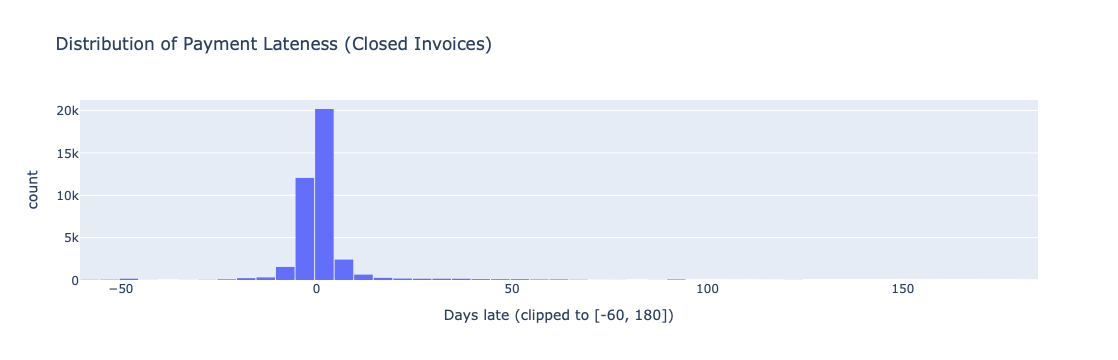

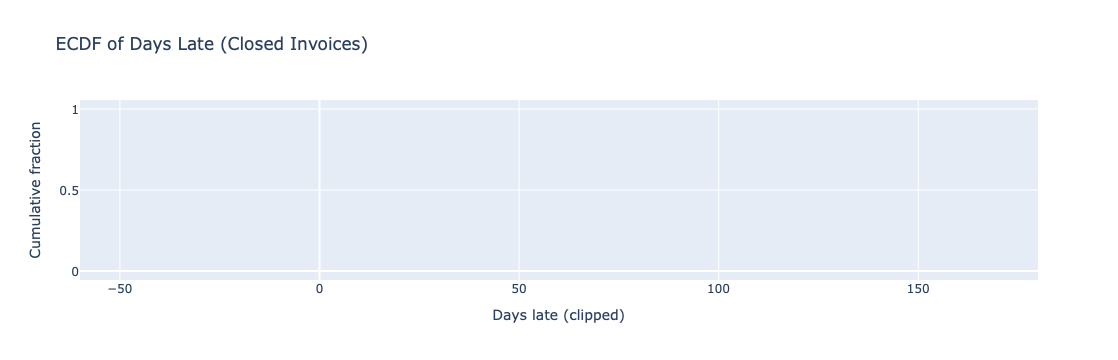

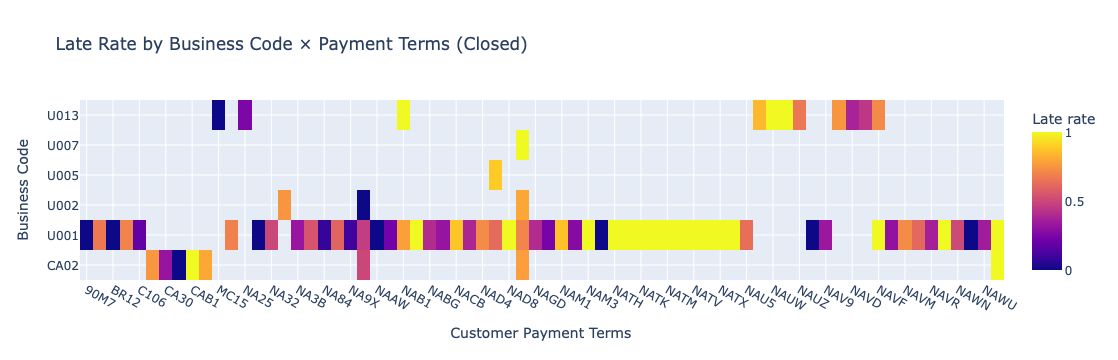

/var/folders/4m/0t9dj_dj6r7cs3h7ks8tv2v40000gn/T/ipykernel_1822/3947451998.py:94: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



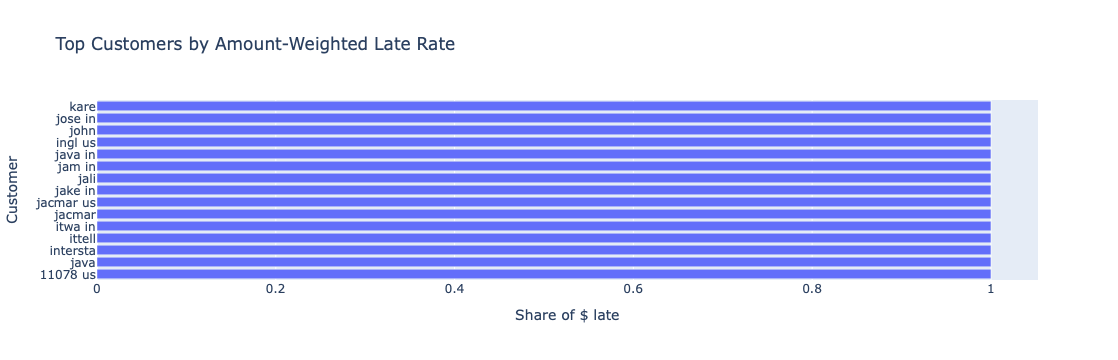

/var/folders/4m/0t9dj_dj6r7cs3h7ks8tv2v40000gn/T/ipykernel_1822/3947451998.py:113: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



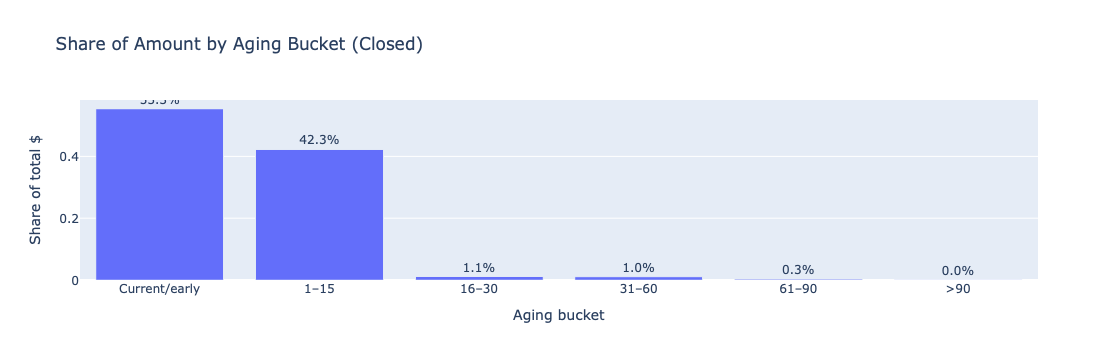

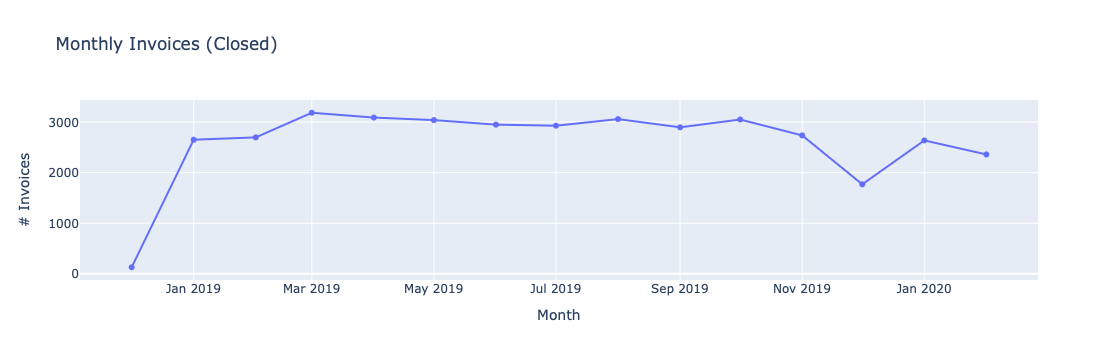

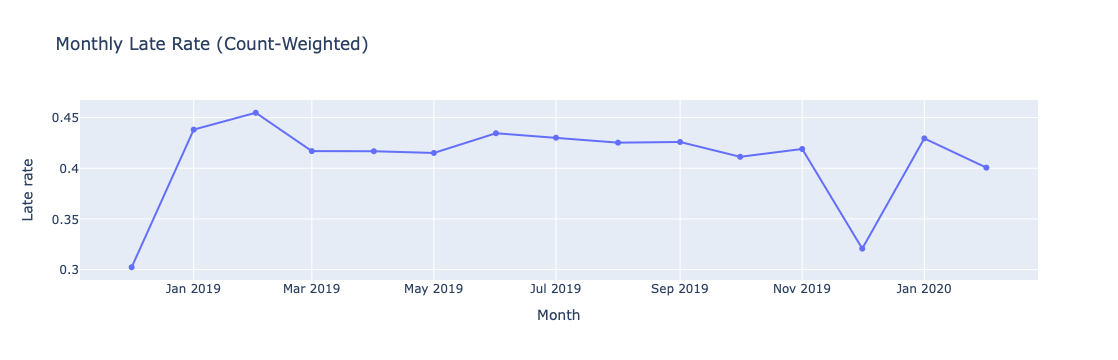

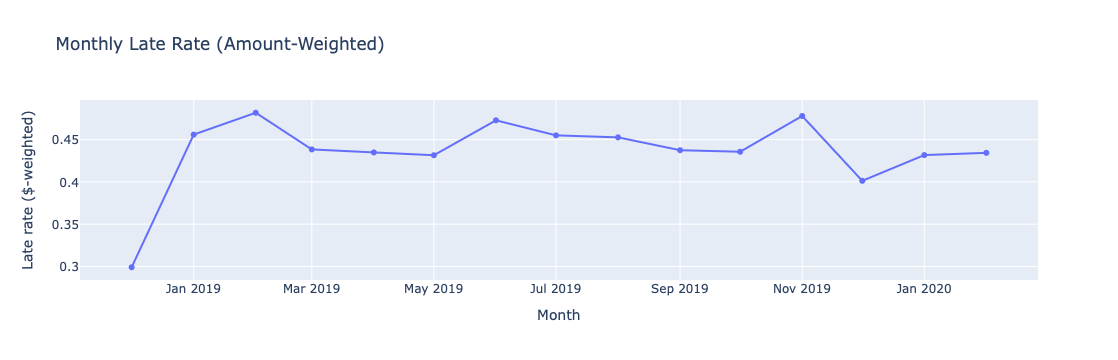

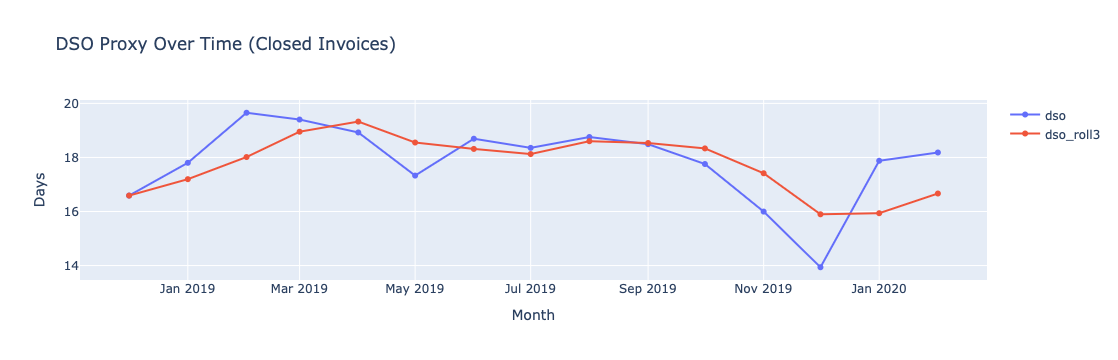

In [11]:
# ===========================================
# Interactive AR Visualizations (Plotly Express)
# Assumptions:
#  - df is already cleaned:
#     * dates parsed (posting_date, due_in_date, clear_date, baseline_create_date)
#     * duplicates dropped
#     * engineered fields exist: days_late, days_to_clear, is_late, aging_bucket
#     * name_customer_std, business_code, cust_payment_terms, total_open_amount
# ===========================================

# Focus only on CLOSED invoices for payment-timeliness visuals
closed_df = df[df["isOpen"].eq(0)].copy()

# -------------------------------------------
# 0) Quick KPIs (optional prints)
# -------------------------------------------
print("Closed invoices:", len(closed_df))
print("On-time share:", (~closed_df["is_late"]).mean().round(3))

# -------------------------------------------
# 1) Distribution of payment lateness (Histogram)
# -------------------------------------------
# Clip tails for display readability only; do NOT clip for metrics
viz_days_late = closed_df["days_late"].dropna().clip(-60, 180)
fig = px.histogram(
    closed_df.assign(viz_days_late=viz_days_late),
    x="viz_days_late",
    nbins=50,
    title="Distribution of Payment Lateness (Closed Invoices)",
    labels={"viz_days_late": "Days late (clipped to [-60, 180])"}
)
fig.update_layout(bargap=0.05)
fig.show()

# -------------------------------------------
# 2) ECDF of days_late (percentile view)
# -------------------------------------------
x = np.sort(viz_days_late.values)
y = np.arange(1, len(x)+1)/len(x)
ecdf_df = pd.DataFrame({"days_late": x, "ecdf": y})
fig = px.line(
    ecdf_df,
    x="days_late", y="ecdf",
    title="ECDF of Days Late (Closed Invoices)",
    labels={"days_late":"Days late (clipped)", "ecdf":"Cumulative fraction"}
)
fig.show()

# -------------------------------------------
# 3) Boxplot by business_code (which units run tighter ops?)
# -------------------------------------------
# Order business codes by median lateness (ascending)
order_bc = (closed_df.groupby("business_code")["days_late"]
            .median().sort_values().index.tolist())
fig = px.box(
    closed_df,
    x="business_code", y="days_late",
    category_orders={"business_code": order_bc},
    points="outliers",
    title="Payment Lateness by Business Code (Closed)",
    labels={"business_code":"Business Code", "days_late":"Days late"}
)
fig.show()

# -------------------------------------------
# 4) Late-rate heatmap by business_code × payment terms
# -------------------------------------------
pivot = (closed_df
         .pivot_table(index="business_code",
                      columns="cust_payment_terms",
                      values="is_late",
                      aggfunc="mean")
         .sort_index())
fig = px.imshow(
    pivot,
    aspect="auto",
    origin="lower",
    title="Late Rate by Business Code × Payment Terms (Closed)",
    labels=dict(x="Customer Payment Terms", y="Business Code", color="Late rate")
)
fig.show()

# -------------------------------------------
# 5) Amount-weighted late rate – top customers (cash-impact)
# -------------------------------------------
def _weighted_kpis(g):
    amt = g["total_open_amount"]
    late = g["is_late"].fillna(False)
    if amt.sum() == 0:
        return pd.Series({"late_rate_amt": np.nan})
    return pd.Series({"late_rate_amt": (amt[late].sum() / amt.sum())})

amt_kpis = (closed_df.groupby("name_customer_std", dropna=False)
                     .apply(_weighted_kpis)
                     .dropna()
                     .sort_values("late_rate_amt", ascending=False))

top15 = amt_kpis.head(15).reset_index()
fig = px.bar(
    top15.sort_values("late_rate_amt"),
    x="late_rate_amt", y="name_customer_std",
    orientation="h",
    title="Top Customers by Amount-Weighted Late Rate",
    labels={"late_rate_amt":"Share of $ late", "name_customer_std":"Customer"}
)
fig.update_layout(yaxis=dict(tickmode="linear"))
fig.show()

# -------------------------------------------
# 6) Aging bucket composition (amount-weighted mix)
# -------------------------------------------
aging_amt = (closed_df
             .groupby("aging_bucket")["total_open_amount"]
             .sum().rename("amount").reset_index())
aging_amt["share"] = aging_amt["amount"] / aging_amt["amount"].sum()
fig = px.bar(
    aging_amt,
    x="aging_bucket", y="share",
    title="Share of Amount by Aging Bucket (Closed)",
    labels={"aging_bucket":"Aging bucket", "share":"Share of total $"},
    text=aging_amt["share"].map(lambda v: f"{v:.1%}")
)
fig.update_traces(textposition="outside")
fig.show()

# -------------------------------------------
# 7) Monthly cohorts – count & amount late rates
# -------------------------------------------
closed_df["post_month"] = closed_df["posting_date"].dt.to_period("M")
cohort = closed_df.groupby("post_month").agg(
    invoices=("doc_id","count"),
    late_rate=("is_late","mean"),
    amt=("total_open_amount","sum")
).reset_index()
amt_late = (closed_df[closed_df["is_late"]]
            .groupby("post_month")["total_open_amount"]
            .sum().rename("amt_late"))
cohort = cohort.merge(amt_late, on="post_month", how="left").fillna({"amt_late":0.0})
cohort["amt_late_rate"] = cohort["amt_late"] / cohort["amt"]
cohort["post_month_ts"] = cohort["post_month"].dt.to_timestamp()

# 7a) invoice count trend
fig = px.line(
    cohort, x="post_month_ts", y="invoices", markers=True,
    title="Monthly Invoices (Closed)",
    labels={"post_month_ts":"Month", "invoices":"# Invoices"}
)
fig.show()

# 7b) late rate by count
fig = px.line(
    cohort, x="post_month_ts", y="late_rate", markers=True,
    title="Monthly Late Rate (Count-Weighted)",
    labels={"post_month_ts":"Month", "late_rate":"Late rate"}
)
fig.show()

# 7c) late rate by amount
fig = px.line(
    cohort, x="post_month_ts", y="amt_late_rate", markers=True,
    title="Monthly Late Rate (Amount-Weighted)",
    labels={"post_month_ts":"Month", "amt_late_rate":"Late rate ($-weighted)"}
)
fig.show()

# -------------------------------------------
# 8) DSO proxy over time + rolling avg
# -------------------------------------------
dso_monthly = (closed_df.groupby("post_month")["days_to_clear"]
               .mean().rename("dso").reset_index())
dso_monthly["post_month_ts"] = dso_monthly["post_month"].dt.to_timestamp()
# 3-month rolling average for smoother signal
dso_monthly["dso_roll3"] = (dso_monthly["dso"]
                            .rolling(3, min_periods=1).mean())

fig = px.line(
    dso_monthly, x="post_month_ts", y=["dso","dso_roll3"], markers=True,
    title="DSO Proxy Over Time (Closed Invoices)",
    labels={"post_month_ts":"Month", "value":"Days", "variable":""}
)
fig.show()


## Insights from the Visualizations

### 1. **Distribution of Payment Lateness**

* The histogram shows most invoices are clustered close to the due date, with a strong peak around **0–10 days late**.
* A smaller but important share is early payments (negative days), but these are far fewer than late ones.
* ECDF confirms: \~80% of invoices are settled within **+/- 10 days of due date**. Beyond +30 days, late payments are rare, but they represent riskier customers.

**Finance takeaway:** Collection risk is moderate overall, but focus should be on the tail (30+ days late). Even a small tail can drive **working capital strain**.

---

### 2. **Payment Lateness by Business Code**

* The boxplots show strong differences across business units. For example:

  * **U001 and CA02** have wider distributions (greater late-payment risk).
  * **U007 and U005** look more stable with tighter payment windows.

**Finance takeaway:** Certain business codes are systematically riskier. This suggests either differences in **customer portfolio** or in **credit/collection policy**.

---

### 3. **Late Rate by Business Code × Payment Terms**

* The heatmap is powerful: some payment terms (e.g., **NATV, NAWU**) systematically push late rates close to **100%**.
* Shorter-term agreements (like 15 days) show variability, while longer-term (30/45/60) often shift risk to late buckets.

**Finance takeaway:** **Customer payment terms are a lever.** Extending terms in some codes doesn’t reduce lateness — it just shifts it. Finance could re-negotiate or tighten policies where heatmap shows structural lateness.

---

### 4. **Top Customers by Amount-Weighted Late Rate**

* Several customers (like **"11078 us"**, **"java"**, **"intersta"**) have **100% of invoice value late**.
* This means even if they aren’t many invoices, they carry **disproportionate financial exposure**.

**Finance takeaway:** These are “watchlist customers.” Even if strategically important, they create **cash flow drag** and should trigger credit monitoring or stricter terms.

---

### 5. **Share of Amount by Aging Bucket**

* \~55% of receivables are **current/early**, and **42% fall in the 1–15 days bucket**.
* Beyond 30 days, the percentages drop to negligible levels (<2%).

**Finance takeaway:** While severe delinquencies (>30 days) are rare, the sheer size of the **1–15 day late bucket** means the company regularly misses its cash-in target by **\~2 weeks**. This can impact liquidity planning.

---

### 6. **Monthly Invoices Trend**

* Volume of invoices is fairly stable (\~2.5–3k/month), suggesting **steady business activity**.
* Seasonal dips appear (Dec–Jan), which could be explained by holiday cycles or year-end adjustments.

**Finance takeaway:** Collections seasonality should be built into **cash forecasting**.

---

### 7. **Monthly Late Rate (Count vs Amount Weighted)**

* Both count-weighted and \$-weighted late rates hover around **40–45%**.
* Amount-weighted is slightly higher in some months → large invoices are **more likely to be late**, amplifying working capital risk.

**Finance takeaway:** Late payment risk is **not evenly distributed** — finance should focus on **high-value invoices** first in collection strategy.

---

### 8. **DSO Proxy Over Time**

* DSO averages around **17–19 days**, dipping to \~14 in late 2019.
* The rolling average smooths the volatility, showing overall stability.

**Finance takeaway:** Collection efficiency is **good and improving**, but volatility (up to ±5 days) suggests certain months bring stress (maybe tied to quarter-end or specific industries/customers).
